<a href="https://colab.research.google.com/github/APWright/6242Project/blob/master/Analysis/GAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set_style("darkgrid")

import pandas as pd
import os
import networkx

In [0]:
!pip install pygam
import pygam

In [0]:
from getpass import getpass
username = input('Github Username: ')
password = getpass('Github Password: ')
clone_repo = "git clone https://{}:{}@github.com/APWright/6242Project.git".format(username,password)
os.system(clone_repo)
password = ""
%cd 6242Project/Analysis

Github Username: apwright
Github Password: ··········
/content/6242Project/Analysis


In [0]:
codes = pd.read_csv("../Data/RawData/iso_codes_numeric_abbrevs.csv")
data_index = ['src_num', 'src_abb', 'tgt_num', 'tgt_abb', 'year']

democracy_score = pd.read_csv("../Data/CleanData/Democracy-Autocracy-score-csv.csv")
gdp_score = pd.read_csv("../Data/CleanData/GDP_per_cap_clean.csv")
avg_temp = pd.read_csv("../Data/CleanData/average_temp_country.csv")
avg_school_years = pd.read_csv("../Data/CleanData/avg_school_years.csv")
birth_rates = pd.read_csv("../Data/CleanData/birth_rates.csv")
land_locked = pd.read_csv("../Data/CleanData/country_land_locked_clean.csv")
water_scaricity = pd.read_csv("../Data/CleanData/country_water_scarcity_clean.csv")
natural_disasters = pd.read_csv("../Data/CleanData/natural_disaster_clean.csv")

trade = pd.read_csv("../Data/CleanData/trade_depencies_clean.csv")
conflict = pd.read_csv("../Data/CleanData/ucdp_conflict2.csv")
edge_features = pd.merge(trade.fillna(0.0),conflict,how='left').fillna(0).rename(columns={'intensity_level':'conflict'})
edge_inv = edge_features.rename(columns={'src_abb':'tgt_abb','src_num':'tgt_num','tgt_abb':'src_abb','tgt_num':'src_num'})
edge_features = pd.merge(edge_features,edge_inv,on=data_index,suffixes=('','_inv'))

migration = pd.read_csv("../Data/CleanData/migration_flows_all_years.csv",index_col=0).rename(columns={'year0':'year',
                                                                                                       'orig': 'src_abb',
                                                                                                       'dest':'tgt_abb',
                                                                                                       'orig_code':'src_num',
                                                                                                       'dest_code':'tgt_num'})
migration['year'] = migration['year'].map(lambda t: int(t[:4]))



node_features = pd.merge(democracy_score,gdp_score, on=data_index)
node_features = pd.merge(node_features,avg_temp, on=data_index).drop(['Unnamed: 0',"Name"],axis=1).rename(columns={'avg':'avg_temp'})
node_features = pd.merge(node_features,avg_school_years, on=data_index)
node_features = pd.merge(node_features,birth_rates, on=data_index)
node_features = pd.merge(node_features,land_locked, on=data_index).drop(['Unnamed: 0',"Country"],axis=1)
water_scaricity['Risk_Level'] = water_scaricity['Risk_Level'].map(lambda rl: {'Extremely-high':5, 'High':4, 'Low':1, 'Low-medium':2, 'Medium-high':3}[rl])
node_features = pd.merge(node_features,water_scaricity, on=data_index).drop(['Unnamed: 0','Rank ',"Country",'Extremely-high', 'High', 'Low', 'Low-medium', 'Medium-high'],axis=1).rename(columns={'Risk_Level':'water_risk'})
node_features = pd.merge(node_features,natural_disasters, on=data_index).drop(['Unnamed: 0',"Country","Prone_Disasters"],axis=1)
node_features = node_features.drop(['src_abb', 'tgt_num', 'tgt_abb'],axis=1)
node_features = node_features.dropna()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [0]:
def print_stats(feat):
  print("\n\n")
  print(feat)
  if len(np.unique(node_features[feat])) < 20:
    print(np.unique(node_features[feat]))
  print(np.mean(node_features[feat]),np.std(node_features[feat]))
[print_stats(feat) for feat in node_features.columns[2:]]

In [0]:
(min(np.unique(migration['year'])),max(np.unique(migration['year']))) 

(1960, 2014)

In [0]:
start_year = 1960
end_year = 2015

In [0]:
node_features = node_features[node_features['year'] >= start_year]
node_features = node_features[node_features['year'] <= end_year]
edge_features = edge_features[edge_features['year'] >= start_year]
edge_features = edge_features[edge_features['year'] <= end_year]

In [0]:
(min(np.unique(node_features['year'])),max(np.unique(node_features['year'])))

(1960, 2015)

In [0]:
regression_df = pd.merge(edge_features,node_features,on=['src_num','year'])
regression_df = pd.merge(regression_df,node_features,left_on=['tgt_num','year'],right_on=['src_num','year'],suffixes=('_src','_tgt'))
regression_df = regression_df.drop(['src_num_tgt'],axis=1)
regression_df = regression_df.rename(columns={'src_num_src':'src_num'})
regression_df

,src_abb,src_num,tgt_abb,tgt_num,year,trade_dependence,conflict,trade_dependence_inv,conflict_inv,democ_src,autoc_src,GDP_per_cap_src,avg_temp_src,years_in_school_src,birth_rateper1000_src,LandLocked_src,water_risk_src,snow_src,tsunami_src,tornado_src,avalanche_src,fire_src,severe_storms_src,mudslide_src,icestorms_src,tropical_storms_src,democ_tgt,autoc_tgt,GDP_per_cap_tgt,avg_temp_tgt,years_in_school_tgt,birth_rateper1000_tgt,LandLocked_tgt,water_risk_tgt,snow_tgt,tsunami_tgt,tornado_tgt,avalanche_tgt,fire_tgt,severe_storms_tgt,mudslide_tgt,icestorms_tgt,tropical_storms_tgt
0,AFG,4.0,AUS,36,1960.0,0.000000,0.0,0.000000,0.0,0,10,59.773194,14.091667,0.220,51.279,1,4,0,0,0,0,0,0,0,0,0,10,0,1807.785710,17.641595,8.260,22.400,0,3,0,0,0,0,1,1,0,0,0
1,AUT,40.0,AUS,36,1960.0,0.002982,0.0,0.000888,0.0,10,0,935.460427,6.900401,5.940,17.900,1,1,0,0,0,1,0,0,0,0,0,10,0,1807.785710,17.641595,8.260,22.400,0,3,0,0,0,0,1,1,0,0,0
2,BEL,56.0,AUS,36,1960.0,0.000000,0.0,0.000000,0.0,10,0,1273.691659,9.473782,6.970,16.800,0,4,0,0,0,0,0,0,0,0,0,10,0,1807.785710,17.641595,8.260,22.400,0,3,0,0,0,0,1,1,0,0,0
3,BEN,204.0,AUS,36,1960.0,0.000000,0.0,0.000000,0.0,4,2,93.022509,26.876528,0.470,44.304,0,1,0,0,0,0,0,0,0,0,0,10,0,1807.785710,17.641595,8.260,22.400,0,3,0,0,0,0,1,1,0,0,0
4,BRA,76.0,AUS,36,1960.0,0.000000,0.0,0.000000,0.0,6,0,210.109899,24.087561,2.490,42.280,0,1,0,0,0,0,0,0,0,0,0,10,0,1807.785710,17.641595,8.260,22.400,0,3,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6031063,BDI,108.0,ARG,32,1983.0,0.000000,0.0,0.000000,0.0,0,7,240.782292,24.133333,1.228,51.600,1,1,0,0,0,0,0,0,0,0,0,8,0,3553.377752,16.310261,7.158,23.451,0,2,0,0,0,0,0,1,0,0,0
6031064,COD,180.0,ARG,32,1983.0,0.000000,0.0,0.000000,0.0,0,8,387.507759,24.660903,1.502,46.226,0,1,0,0,0,0,0,0,0,0,0,8,0,3553.377752,16.310261,7.158,23.451,0,2,0,0,0,0,0,1,0,0,0
6031065,COD,180.0,ARG,32,1983.0,0.000000,0.0,0.000000,0.0,0,8,387.507759,23.809861,1.502,46.226,0,1,0,0,0,0,0,0,0,0,0,8,0,3553.377752,16.310261,7.158,23.451,0,2,0,0,0,0,0,1,0,0,0
6031066,LSO,426.0,ARG,32,1983.0,0.000000,0.0,0.000000,0.0,0,7,266.188377,14.732857,3.948,40.661,1,3,0,0,0,0,0,0,0,0,0,8,0,3553.377752,16.310261,7.158,23.451,0,2,0,0,0,0,0,1,0,0,0


In [0]:
migration

,year,src_abb,tgt_abb,src_num,tgt_num,flow
1,1960,ABW,ABW,533,533,0.0
2,1961,ABW,ABW,533,533,0.0
3,1962,ABW,ABW,533,533,0.0
4,1963,ABW,ABW,533,533,0.0
5,1964,ABW,ABW,533,533,0.0
...,...,...,...,...,...,...
2069976,2010,ZWE,ZWE,716,716,0.0
2069977,2011,ZWE,ZWE,716,716,0.0
2069978,2012,ZWE,ZWE,716,716,0.0
2069979,2013,ZWE,ZWE,716,716,0.0


In [0]:
total_regression_df = pd.merge(migration,regression_df,on=data_index)
total_regression_df

,year,src_abb,tgt_abb,src_num,tgt_num,flow,trade_dependence,conflict,trade_dependence_inv,conflict_inv,democ_src,autoc_src,GDP_per_cap_src,avg_temp_src,years_in_school_src,birth_rateper1000_src,LandLocked_src,water_risk_src,snow_src,tsunami_src,tornado_src,avalanche_src,fire_src,severe_storms_src,mudslide_src,icestorms_src,tropical_storms_src,democ_tgt,autoc_tgt,GDP_per_cap_tgt,avg_temp_tgt,years_in_school_tgt,birth_rateper1000_tgt,LandLocked_tgt,water_risk_tgt,snow_tgt,tsunami_tgt,tornado_tgt,avalanche_tgt,fire_tgt,severe_storms_tgt,mudslide_tgt,icestorms_tgt,tropical_storms_tgt
0,2014,AFG,ALB,4,8,0.0,5.412775e-07,0.0,0.000000,0.0,1,2,613.856333,17.6825,3.5,35.706,1,4,0,0,0,0,0,0,0,0,0,9,0,4578.667934,15.873333,9.70,12.259,0,4,0,1,0,0,0,0,0,0,0
1,2014,AFG,ALB,4,8,0.0,5.412775e-07,0.0,0.000000,0.0,1,2,613.856333,17.6825,3.5,35.706,1,4,0,0,0,0,0,0,0,0,0,9,0,4578.667934,15.873333,9.70,12.259,0,4,0,1,0,0,0,0,0,0,0
2,2014,AFG,ALB,4,8,0.0,5.412775e-07,0.0,0.000000,0.0,1,2,613.856333,17.6825,3.5,35.706,1,4,0,0,0,0,0,0,0,0,0,9,0,4578.667934,15.873333,9.64,12.259,0,4,0,1,0,0,0,0,0,0,0
3,2014,AFG,ALB,4,8,0.0,5.412775e-07,0.0,0.000000,0.0,1,2,613.856333,17.6825,3.5,35.706,1,4,0,0,0,0,0,0,0,0,0,9,0,4578.667934,15.873333,9.48,12.259,0,4,0,1,0,0,0,0,0,0,0
4,2014,AFG,ALB,4,8,0.0,5.412775e-07,0.0,0.000000,0.0,1,2,613.856333,17.6825,3.5,35.706,1,4,0,0,0,0,0,0,0,0,0,9,0,4578.667934,15.873333,9.30,12.259,0,4,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5752563,2014,ZWE,ZMB,716,894,822.0,1.534505e-02,0.0,0.077022,0.0,5,1,1434.899340,19.8650,7.3,34.978,1,2,0,0,0,0,0,1,0,0,0,7,0,1763.056239,23.883333,6.90,38.645,1,1,0,0,0,0,0,1,0,0,1
5752564,2014,ZWE,ZMB,716,894,822.0,1.534505e-02,0.0,0.077022,0.0,5,1,1434.899340,19.8650,7.3,34.978,1,2,0,0,0,0,0,1,0,0,0,7,0,1763.056239,23.883333,6.82,38.645,1,1,0,0,0,0,0,1,0,0,1
5752565,2014,ZWE,ZMB,716,894,822.0,1.534505e-02,0.0,0.077022,0.0,5,1,1434.899340,19.8650,7.3,34.978,1,2,0,0,0,0,0,1,0,0,0,7,0,1763.056239,23.883333,6.74,38.645,1,1,0,0,0,0,0,1,0,0,1
5752566,2014,ZWE,ZMB,716,894,822.0,1.534505e-02,0.0,0.077022,0.0,5,1,1434.899340,19.8650,7.3,34.978,1,2,0,0,0,0,0,1,0,0,0,7,0,1763.056239,23.883333,6.70,38.645,1,1,0,0,0,0,0,1,0,0,1


In [194]:
total_regression_df = total_regression_df[total_regression_df.flow>1]
total_regression_df

,year,src_abb,tgt_abb,src_num,tgt_num,flow,trade_dependence,conflict,trade_dependence_inv,conflict_inv,democ_src,autoc_src,GDP_per_cap_src,avg_temp_src,years_in_school_src,birth_rateper1000_src,LandLocked_src,water_risk_src,snow_src,tsunami_src,tornado_src,avalanche_src,fire_src,severe_storms_src,mudslide_src,icestorms_src,tropical_storms_src,democ_tgt,autoc_tgt,GDP_per_cap_tgt,avg_temp_tgt,years_in_school_tgt,birth_rateper1000_tgt,LandLocked_tgt,water_risk_tgt,snow_tgt,tsunami_tgt,tornado_tgt,avalanche_tgt,fire_tgt,severe_storms_tgt,mudslide_tgt,icestorms_tgt,tropical_storms_tgt
38,1975,AFG,ARG,4,32,5.4,0.000000,0.0,0.000000,0.0,0,7,186.510897,17.111667,0.620,50.930,1,4,0,0,0,0,0,0,0,0,0,6,0,2027.337124,16.415428,6.430,24.912,0,2,0,0,0,0,0,1,0,0,0
39,1976,AFG,ARG,4,32,5.4,0.000000,0.0,0.000000,0.0,0,7,197.445508,17.115000,0.652,50.803,1,4,0,0,0,0,0,0,0,0,0,0,9,1948.224686,16.008501,6.488,25.191,0,2,0,0,0,0,0,1,0,0,0
40,1977,AFG,ARG,4,32,5.4,0.000000,0.0,0.000000,0.0,0,7,224.224797,15.901500,0.684,50.678,1,4,0,0,0,0,0,0,0,0,0,0,9,2129.708281,16.576341,6.546,25.320,0,2,0,0,0,0,0,1,0,0,0
91,1960,AFG,AUS,4,36,2.8,0.000000,0.0,0.000000,0.0,0,10,59.773194,14.091667,0.220,51.279,1,4,0,0,0,0,0,0,0,0,0,10,0,1807.785710,17.641595,8.260,22.400,0,3,0,0,0,0,1,1,0,0,0
92,1961,AFG,AUS,4,36,2.8,0.000000,0.0,0.000000,0.0,0,10,59.860874,19.986944,0.234,51.373,1,4,0,0,0,0,0,0,0,0,0,10,0,1874.838940,18.354420,8.314,22.900,0,3,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5752563,2014,ZWE,ZMB,716,894,822.0,0.015345,0.0,0.077022,0.0,5,1,1434.899340,19.865000,7.300,34.978,1,2,0,0,0,0,0,1,0,0,0,7,0,1763.056239,23.883333,6.900,38.645,1,1,0,0,0,0,0,1,0,0,1
5752564,2014,ZWE,ZMB,716,894,822.0,0.015345,0.0,0.077022,0.0,5,1,1434.899340,19.865000,7.300,34.978,1,2,0,0,0,0,0,1,0,0,0,7,0,1763.056239,23.883333,6.820,38.645,1,1,0,0,0,0,0,1,0,0,1
5752565,2014,ZWE,ZMB,716,894,822.0,0.015345,0.0,0.077022,0.0,5,1,1434.899340,19.865000,7.300,34.978,1,2,0,0,0,0,0,1,0,0,0,7,0,1763.056239,23.883333,6.740,38.645,1,1,0,0,0,0,0,1,0,0,1
5752566,2014,ZWE,ZMB,716,894,822.0,0.015345,0.0,0.077022,0.0,5,1,1434.899340,19.865000,7.300,34.978,1,2,0,0,0,0,0,1,0,0,0,7,0,1763.056239,23.883333,6.700,38.645,1,1,0,0,0,0,0,1,0,0,1


In [0]:
for i in range(len(total_regression_df.columns[6:])):
  col = total_regression_df.columns[6:][i]
  print("{} {}  {}".format(i,col,len(np.unique(regression_df[col]))))

0 trade_dependence  232663
1 conflict  3
2 trade_dependence_inv  232663
3 conflict_inv  3
4 democ_src  11
5 autoc_src  11
6 GDP_per_cap_src  4723
7 avg_temp_src  4677
8 years_in_school_src  2332
9 birth_rateper1000_src  3462
10 LandLocked_src  2
11 water_risk_src  5
12 snow_src  2
13 tsunami_src  2
14 tornado_src  2
15 avalanche_src  2
16 fire_src  2
17 severe_storms_src  2
18 mudslide_src  2
19 icestorms_src  2
20 tropical_storms_src  2
21 democ_tgt  11
22 autoc_tgt  11
23 GDP_per_cap_tgt  4723
24 avg_temp_tgt  4677
25 years_in_school_tgt  2332
26 birth_rateper1000_tgt  3462
27 LandLocked_tgt  2
28 water_risk_tgt  5
29 snow_tgt  2
30 tsunami_tgt  2
31 tornado_tgt  2
32 avalanche_tgt  2
33 fire_tgt  2
34 severe_storms_tgt  2
35 mudslide_tgt  2
36 icestorms_tgt  2
37 tropical_storms_tgt  2


In [0]:
from pygam import InvGaussGAM, GAM, LinearGAM, s, f
# gam = LinearGAM(s(0)+f(1)+s(2)+f(3)+s(4)+s(5)+s(6)+s(7)+s(8)+s(9)+f(10)+s(11)+f(12)+f(13)+f(14)+f(15)+f(16)+f(17)+f(18)+f(19)+f(20)+s(21)+s(22)+s(23)+s(24)+s(25)+s(26)+f(27)+s(28)+f(29)+f(30)+f(31)+f(32)+f(33)+f(34)+f(35)+f(36)+f(37))
# gam = LinearGAM(s(0)+s(1)+s(2)+s(3)+s(4)+s(5)+s(6)+s(7)+s(8)+s(9)+s(10)+s(11)+s(12)+s(13)+s(14)+s(15)+s(16)+s(17)+s(18)+s(19)+s(20)+s(21)+s(22)+s(23)+s(24)+s(25)+s(26)+s(27)+s(28)+s(29)+s(30)+s(31)+s(32)+s(33)+s(34)+s(35)+s(36)+s(37))
gam = LinearGAM()

In [0]:
y = np.log(total_regression_df['flow'])
X = total_regression_df[total_regression_df.columns[6:]].values
train_index = np.random.rand(len(y)) <= 0.01
test_index  = ~train_index
gam = gam.fit(X[train_index],y[train_index])

In [0]:
from google.colab import files
import pickle

save_model=  open("gam.pkl",mode='wb')
pickle.dump(gam,save_model)
files.download('gam.pkl')

In [0]:
load_model =  open("gam.pkl",mode='rb')

gam = pickle.load(load_model)

In [281]:
np.std(gam.predict(X[train_index]) - y[train_index])

1.8558058209464254

In [291]:
np.exp(2*1.8558058209464254)

40.91970131821174

In [277]:
np.mean(gam.predict(X[train_index])),np.mean(y[train_index])

(3.6433624579502197, 3.643362457952428)

(0, 1e-05)

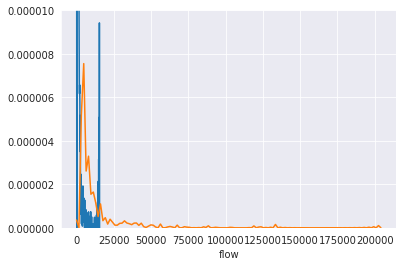

In [288]:
sns.distplot(np.exp(gam.predict(X[train_index])) ,hist=False)
sns.distplot(np.exp(y[train_index]),hist=False)
plt.ylim(0,0.00001)

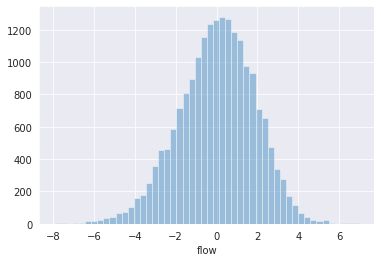

In [295]:
sns.distplot(gam.predict(X[train_index]) - y[train_index],kde=False)

In [0]:
pred = gam.predict(X)

In [356]:
np.std(y)

2.3162103477283322

In [298]:
np.std(pred - y)

1.880793778537907

In [359]:
1.0-(np.std(pred - y)/np.std(y))

0.1879866263517337

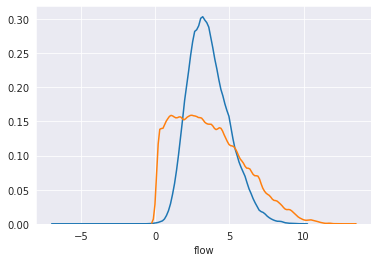

In [339]:
sns.distplot(pred,hist=False)
sns.distplot(y,hist=False)

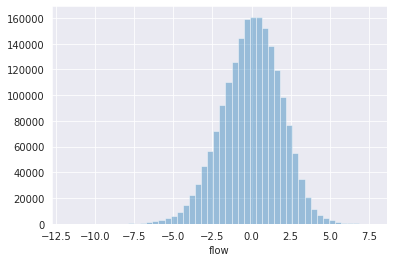

In [300]:
sns.distplot((pred - y),kde=False)

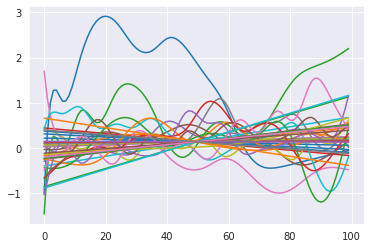

In [302]:
plt.figure()
for i, term in enumerate(gam.terms):
    if i < 0:
      continue
    if term.isintercept:
        continue
    plt.plot(gam.partial_dependence(term=i))

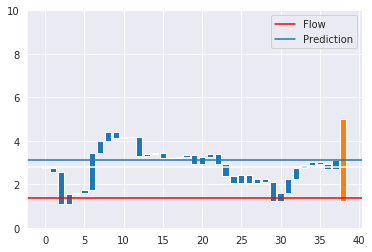

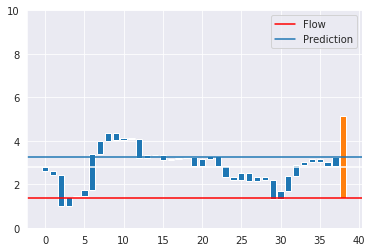

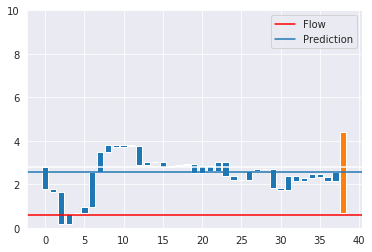

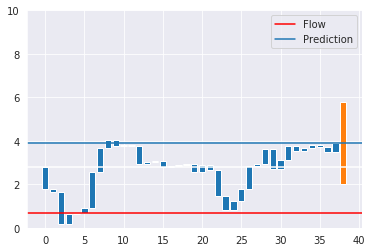

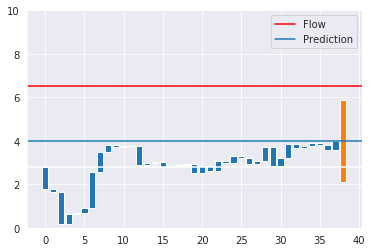

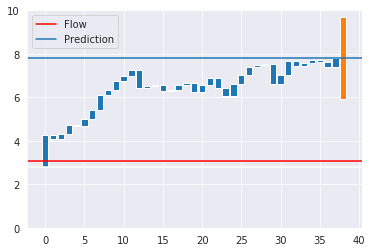

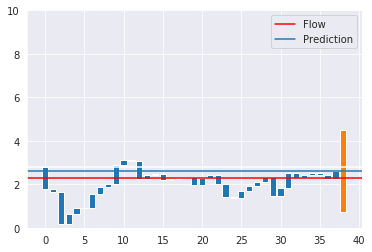

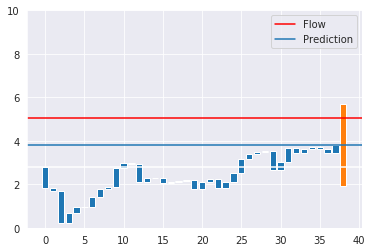

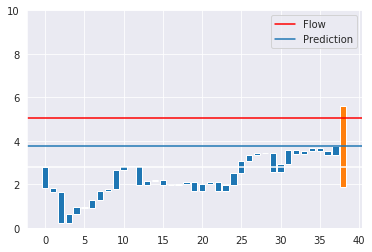

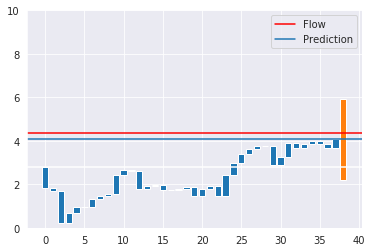

In [355]:
for j in range(10):
  locs = [i for i in range(len(gam.terms)-1)]
  factors=np.array([gam.partial_dependence(term=i,X=X[train_index][j].reshape(1,-1)) for i in range(len(gam.terms)-1)]).ravel()
  cum_factors = [gam.coef_[-1]]
  for factor in factors:
    cum_factors.append(factor+cum_factors[-1])
  cum_factors = cum_factors[:-1]
  plt.bar(locs,factors,bottom=cum_factors)
  plt.bar([locs[-1]+1],[2*1.88],bottom=[pred[train_index][j]-1.88])
  plt.axhline(y=list(y[train_index])[j],c='r',label='Flow')
  plt.axhline(y=pred[train_index][j],label="Prediction")
  plt.axhline(y=gam.coef_[-1],c='w')
  plt.ylim(0,10)
  plt.legend()
  plt.show()

In [363]:
factors=np.array([gam.partial_dependence(term=i,X=X.reshape(-1,38)) for i in range(len(gam.terms)-1)]).T
factors.shape

(1948195, 38)

In [0]:
factor_df = pd.DataFrame(data=factors,columns=total_regression_df.columns[6:])

In [365]:
factor_df

,trade_dependence,conflict,trade_dependence_inv,conflict_inv,democ_src,autoc_src,GDP_per_cap_src,avg_temp_src,years_in_school_src,birth_rateper1000_src,LandLocked_src,water_risk_src,snow_src,tsunami_src,tornado_src,avalanche_src,fire_src,severe_storms_src,mudslide_src,icestorms_src,tropical_storms_src,democ_tgt,autoc_tgt,GDP_per_cap_tgt,avg_temp_tgt,years_in_school_tgt,birth_rateper1000_tgt,LandLocked_tgt,water_risk_tgt,snow_tgt,tsunami_tgt,tornado_tgt,avalanche_tgt,fire_tgt,severe_storms_tgt,mudslide_tgt,icestorms_tgt,tropical_storms_tgt
0,-1.00379,-0.163427,-1.455937,0.444576,0.046952,0.257827,1.617462,0.925130,0.329931,-0.077355,0.059933,-0.030379,-0.852897,0.101705,0.033876,-0.244622,0.030694,0.044182,0.066761,-0.397,0.313654,0.571112,-0.433974,-0.572459,0.682032,0.378508,0.291972,0.096899,-0.031517,-0.883986,0.377047,0.662485,-0.226338,0.130515,0.131912,-0.113111,-0.198232,0.399384
1,-1.00379,-0.163427,-1.455937,0.444576,0.046952,0.257827,1.611359,0.926317,0.321589,-0.030973,0.059933,-0.030379,-0.852897,0.101705,0.033876,-0.244622,0.030694,0.044182,0.066761,-0.397,0.313654,-0.233766,-1.174025,-0.576445,0.777276,0.382125,0.260435,0.096899,-0.031517,-0.883986,0.377047,0.662485,-0.226338,0.130515,0.131912,-0.113111,-0.198232,0.399384
2,-1.00379,-0.163427,-1.455937,0.444576,0.046952,0.257827,1.596492,0.441495,0.312700,0.014176,0.059933,-0.030379,-0.852897,0.101705,0.033876,-0.244622,0.030694,0.044182,0.066761,-0.397,0.313654,-0.233766,-1.174025,-0.567228,0.642490,0.378650,0.245340,0.096899,-0.031517,-0.883986,0.377047,0.662485,-0.226338,0.130515,0.131912,-0.113111,-0.198232,0.399384
3,-1.00379,-0.163427,-1.455937,0.444576,0.046952,0.154439,1.689600,0.113920,0.389335,-0.206081,0.059933,-0.030379,-0.852897,0.101705,0.033876,-0.244622,0.030694,0.044182,0.066761,-0.397,0.313654,0.123892,-0.433974,-0.583388,0.554221,0.558151,0.308499,0.096899,0.019842,-0.883986,0.377047,0.662485,-0.226338,0.149718,0.131912,-0.113111,-0.198232,0.399384
4,-1.00379,-0.163427,-1.455937,0.444576,0.046952,0.154439,1.689549,0.344084,0.388621,-0.240743,0.059933,-0.030379,-0.852897,0.101705,0.033876,-0.244622,0.030694,0.044182,0.066761,-0.397,0.313654,0.123892,-0.433974,-0.580094,0.544965,0.561408,0.365977,0.096899,0.019842,-0.883986,0.377047,0.662485,-0.226338,0.149718,0.131912,-0.113111,-0.198232,0.399384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1948190,0.96171,-0.163427,0.840629,0.444576,0.267403,0.071492,1.036014,0.367681,0.136448,-0.259381,0.059933,0.279182,-0.852897,0.101705,0.033876,-0.244622,0.030694,0.236052,0.066761,-0.397,0.313654,0.095069,-0.433974,-0.585563,0.083437,0.272025,0.432778,0.183333,-0.143158,-0.883986,0.377047,0.662485,-0.226338,0.130515,0.131912,-0.113111,-0.198232,-0.119153
1948191,0.96171,-0.163427,0.840629,0.444576,0.267403,0.071492,1.036014,0.367681,0.136448,-0.259381,0.059933,0.279182,-0.852897,0.101705,0.033876,-0.244622,0.030694,0.236052,0.066761,-0.397,0.313654,0.095069,-0.433974,-0.585563,0.083437,0.301708,0.432778,0.183333,-0.143158,-0.883986,0.377047,0.662485,-0.226338,0.130515,0.131912,-0.113111,-0.198232,-0.119153
1948192,0.96171,-0.163427,0.840629,0.444576,0.267403,0.071492,1.036014,0.367681,0.136448,-0.259381,0.059933,0.279182,-0.852897,0.101705,0.033876,-0.244622,0.030694,0.236052,0.066761,-0.397,0.313654,0.095069,-0.433974,-0.585563,0.083437,0.330602,0.432778,0.183333,-0.143158,-0.883986,0.377047,0.662485,-0.226338,0.130515,0.131912,-0.113111,-0.198232,-0.119153
1948193,0.96171,-0.163427,0.840629,0.444576,0.267403,0.071492,1.036014,0.367681,0.136448,-0.259381,0.059933,0.279182,-0.852897,0.101705,0.033876,-0.244622,0.030694,0.236052,0.066761,-0.397,0.313654,0.095069,-0.433974,-0.585563,0.083437,0.343798,0.432778,0.183333,-0.143158,-0.883986,0.377047,0.662485,-0.226338,0.130515,0.131912,-0.113111,-0.198232,-0.119153


In [375]:
total_regression_df = total_regression_df.reset_index()
total_regression_df

,level_0,index,year,src_abb,tgt_abb,src_num,tgt_num,flow,trade_dependence,conflict,trade_dependence_inv,conflict_inv,democ_src,autoc_src,GDP_per_cap_src,avg_temp_src,years_in_school_src,birth_rateper1000_src,LandLocked_src,water_risk_src,snow_src,tsunami_src,tornado_src,avalanche_src,fire_src,severe_storms_src,mudslide_src,icestorms_src,tropical_storms_src,democ_tgt,autoc_tgt,GDP_per_cap_tgt,avg_temp_tgt,years_in_school_tgt,birth_rateper1000_tgt,LandLocked_tgt,water_risk_tgt,snow_tgt,tsunami_tgt,tornado_tgt,avalanche_tgt,fire_tgt,severe_storms_tgt,mudslide_tgt,icestorms_tgt,tropical_storms_tgt
0,0,38,1975,AFG,ARG,4,32,5.4,0.000000,0.0,0.000000,0.0,0,7,186.510897,17.111667,0.620,50.930,1,4,0,0,0,0,0,0,0,0,0,6,0,2027.337124,16.415428,6.430,24.912,0,2,0,0,0,0,0,1,0,0,0
1,1,39,1976,AFG,ARG,4,32,5.4,0.000000,0.0,0.000000,0.0,0,7,197.445508,17.115000,0.652,50.803,1,4,0,0,0,0,0,0,0,0,0,0,9,1948.224686,16.008501,6.488,25.191,0,2,0,0,0,0,0,1,0,0,0
2,2,40,1977,AFG,ARG,4,32,5.4,0.000000,0.0,0.000000,0.0,0,7,224.224797,15.901500,0.684,50.678,1,4,0,0,0,0,0,0,0,0,0,0,9,2129.708281,16.576341,6.546,25.320,0,2,0,0,0,0,0,1,0,0,0
3,3,91,1960,AFG,AUS,4,36,2.8,0.000000,0.0,0.000000,0.0,0,10,59.773194,14.091667,0.220,51.279,1,4,0,0,0,0,0,0,0,0,0,10,0,1807.785710,17.641595,8.260,22.400,0,3,0,0,0,0,1,1,0,0,0
4,4,92,1961,AFG,AUS,4,36,2.8,0.000000,0.0,0.000000,0.0,0,10,59.860874,19.986944,0.234,51.373,1,4,0,0,0,0,0,0,0,0,0,10,0,1874.838940,18.354420,8.314,22.900,0,3,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1948190,1948190,5752563,2014,ZWE,ZMB,716,894,822.0,0.015345,0.0,0.077022,0.0,5,1,1434.899340,19.865000,7.300,34.978,1,2,0,0,0,0,0,1,0,0,0,7,0,1763.056239,23.883333,6.900,38.645,1,1,0,0,0,0,0,1,0,0,1
1948191,1948191,5752564,2014,ZWE,ZMB,716,894,822.0,0.015345,0.0,0.077022,0.0,5,1,1434.899340,19.865000,7.300,34.978,1,2,0,0,0,0,0,1,0,0,0,7,0,1763.056239,23.883333,6.820,38.645,1,1,0,0,0,0,0,1,0,0,1
1948192,1948192,5752565,2014,ZWE,ZMB,716,894,822.0,0.015345,0.0,0.077022,0.0,5,1,1434.899340,19.865000,7.300,34.978,1,2,0,0,0,0,0,1,0,0,0,7,0,1763.056239,23.883333,6.740,38.645,1,1,0,0,0,0,0,1,0,0,1
1948193,1948193,5752566,2014,ZWE,ZMB,716,894,822.0,0.015345,0.0,0.077022,0.0,5,1,1434.899340,19.865000,7.300,34.978,1,2,0,0,0,0,0,1,0,0,0,7,0,1763.056239,23.883333,6.700,38.645,1,1,0,0,0,0,0,1,0,0,1


In [384]:
master_df = total_regression_df.join(factor_df,rsuffix="_factor")
master_df = master_df.drop(columns=['level_0','index'])
master_df['bias_factor'] = gam.coef_[-1]
master_df['log_prediction'] = pred
master_df['flow_prediction'] = np.exp(pred)
master_df['log_prediction_accuracy_sigma'] = np.std(pred - y)
master_df

,year,src_abb,tgt_abb,src_num,tgt_num,flow,trade_dependence,conflict,trade_dependence_inv,conflict_inv,democ_src,autoc_src,GDP_per_cap_src,avg_temp_src,years_in_school_src,birth_rateper1000_src,LandLocked_src,water_risk_src,snow_src,tsunami_src,tornado_src,avalanche_src,fire_src,severe_storms_src,mudslide_src,icestorms_src,tropical_storms_src,democ_tgt,autoc_tgt,GDP_per_cap_tgt,avg_temp_tgt,years_in_school_tgt,birth_rateper1000_tgt,LandLocked_tgt,water_risk_tgt,snow_tgt,tsunami_tgt,tornado_tgt,avalanche_tgt,fire_tgt,...,trade_dependence_inv_factor,conflict_inv_factor,democ_src_factor,autoc_src_factor,GDP_per_cap_src_factor,avg_temp_src_factor,years_in_school_src_factor,birth_rateper1000_src_factor,LandLocked_src_factor,water_risk_src_factor,snow_src_factor,tsunami_src_factor,tornado_src_factor,avalanche_src_factor,fire_src_factor,severe_storms_src_factor,mudslide_src_factor,icestorms_src_factor,tropical_storms_src_factor,democ_tgt_factor,autoc_tgt_factor,GDP_per_cap_tgt_factor,avg_temp_tgt_factor,years_in_school_tgt_factor,birth_rateper1000_tgt_factor,LandLocked_tgt_factor,water_risk_tgt_factor,snow_tgt_factor,tsunami_tgt_factor,tornado_tgt_factor,avalanche_tgt_factor,fire_tgt_factor,severe_storms_tgt_factor,mudslide_tgt_factor,icestorms_tgt_factor,tropical_storms_tgt_factor,bias_factor,log_prediction,flow_prediction,log_prediction_accuracy_sigma
0,1975,AFG,ARG,4,32,5.4,0.000000,0.0,0.000000,0.0,0,7,186.510897,17.111667,0.620,50.930,1,4,0,0,0,0,0,0,0,0,0,6,0,2027.337124,16.415428,6.430,24.912,0,2,0,0,0,0,0,...,-1.455937,0.444576,0.046952,0.257827,1.617462,0.925130,0.329931,-0.077355,0.059933,-0.030379,-0.852897,0.101705,0.033876,-0.244622,0.030694,0.044182,0.066761,-0.397,0.313654,0.571112,-0.433974,-0.572459,0.682032,0.378508,0.291972,0.096899,-0.031517,-0.883986,0.377047,0.662485,-0.226338,0.130515,0.131912,-0.113111,-0.198232,0.399384,2.802297,4.111821,61.057797,1.880794
1,1976,AFG,ARG,4,32,5.4,0.000000,0.0,0.000000,0.0,0,7,197.445508,17.115000,0.652,50.803,1,4,0,0,0,0,0,0,0,0,0,0,9,1948.224686,16.008501,6.488,25.191,0,2,0,0,0,0,0,...,-1.455937,0.444576,0.046952,0.257827,1.611359,0.926317,0.321589,-0.030973,0.059933,-0.030379,-0.852897,0.101705,0.033876,-0.244622,0.030694,0.044182,0.066761,-0.397,0.313654,-0.233766,-1.174025,-0.576445,0.777276,0.382125,0.260435,0.096899,-0.031517,-0.883986,0.377047,0.662485,-0.226338,0.130515,0.131912,-0.113111,-0.198232,0.399384,2.802297,2.663354,14.344314,1.880794
2,1977,AFG,ARG,4,32,5.4,0.000000,0.0,0.000000,0.0,0,7,224.224797,15.901500,0.684,50.678,1,4,0,0,0,0,0,0,0,0,0,0,9,2129.708281,16.576341,6.546,25.320,0,2,0,0,0,0,0,...,-1.455937,0.444576,0.046952,0.257827,1.596492,0.441495,0.312700,0.014176,0.059933,-0.030379,-0.852897,0.101705,0.033876,-0.244622,0.030694,0.044182,0.066761,-0.397,0.313654,-0.233766,-1.174025,-0.567228,0.642490,0.378650,0.245340,0.096899,-0.031517,-0.883986,0.377047,0.662485,-0.226338,0.130515,0.131912,-0.113111,-0.198232,0.399384,2.802297,2.055787,7.812983,1.880794
3,1960,AFG,AUS,4,36,2.8,0.000000,0.0,0.000000,0.0,0,10,59.773194,14.091667,0.220,51.279,1,4,0,0,0,0,0,0,0,0,0,10,0,1807.785710,17.641595,8.260,22.400,0,3,0,0,0,0,1,...,-1.455937,0.444576,0.046952,0.154439,1.689600,0.113920,0.389335,-0.206081,0.059933,-0.030379,-0.852897,0.101705,0.033876,-0.244622,0.030694,0.044182,0.066761,-0.397,0.313654,0.123892,-0.433974,-0.583388,0.554221,0.558151,0.308499,0.096899,0.019842,-0.883986,0.377047,0.662485,-0.226338,0.149718,0.131912,-0.113111,-0.198232,0.399384,2.802297,2.880810,17.828716,1.880794
4,1961,AFG,AUS,4,36,2.8,0.000000,0.0,0.000000,0.0,0,10,59.860874,19.986944,0.234,51.373,1,4,0,0,0,0,0,0,0,0,0,10,0,1874.838940,18.354420,8.314,22.900,0,3,0,0,0,0,1,...,-1.455937,0.444576,0.046952,0.154439,1.689549,0.344084,0.388621,-0.240743,0.059933,-0.030379,-0.852897,0.101705,0.033876,-0.244622,0.030694,0.044182,0.066761,-0.397,0.313654,0.123892,-0.433974,-0.580094,0.544965,0.561408,0.365977,0.096899,0.019842,-0.883986,0.377047,0.662485,-0.226338,0.149718,0.131912,-0.1131

In [0]:
master_df.to_csv('master_table.csv',index=False,)

In [390]:
migration

,year,src_abb,tgt_abb,src_num,tgt_num,flow
1,1960,ABW,ABW,533,533,0.0
2,1961,ABW,ABW,533,533,0.0
3,1962,ABW,ABW,533,533,0.0
4,1963,ABW,ABW,533,533,0.0
5,1964,ABW,ABW,533,533,0.0
...,...,...,...,...,...,...
2069976,2010,ZWE,ZWE,716,716,0.0
2069977,2011,ZWE,ZWE,716,716,0.0
2069978,2012,ZWE,ZWE,716,716,0.0
2069979,2013,ZWE,ZWE,716,716,0.0
